# **Subset CONUS and run ParFlow-CLM**

To launch this notebook interactively in a Jupyter notebook-like browser interface, please click the "Launch Binder" button below. Note that Binder may take several minutes to launch.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/hydroframe/subsettools-binder/HEAD?labpath=subsettools%2Fconus1_subsetting_transient.ipynb)

This notebook walks through an example of subsetting a HUC8 from the CONUS1 domain. This example will subset everything needed to do a transient run with ParFlow-CLM. 
This is includes all hydrogeologic datasets and climate forcing data from NLDAS2 (see additional DOI: [10.1002/2016GL069964](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016GL069964)). All of the data is written to a folder for the specified days to run. This example uses the template runscript conus1_pfclm_transient_solid.yaml and edits it to correspond with the domain subset. It also sets-up and performs the designed simulation. The result will be model output pressure and saturation pfbs according to the days specified.

### This notebook has two principal sections: 
1. Subset all static inputs and climate forcings from a CONUS run stored in Hydrodata 
2. Load and alter a reference run to set up and perform your ParFlow-CLM subset.

### Import the required libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from parflow import Run
from parflow.tools.io import read_pfb, read_clm
from parflow.tools.fs import mkdir
from parflow.tools.settings import set_working_directory
import subsettools as st
import hf_hydrodata as hf

In [2]:
# You need to register on https://hydrogen.princeton.edu/pin before you can use the hydrodata utilities
hf.register_api_pin("your_email", "your_pin")

### 1. Define variables to access datasets in Hydrodata to subset and define write paths

#### We will be testing with the Upper Verde watershed for this example
- HUC: 15060202
- Size: 6496 km^2 (ni = 112, nj = 90)   

#### Set your variables to specify which static and climate forcing data you would like to subset in Hydrodata

In [3]:
runname = "conus1_upper_verde"

# provide a way to create a subset from the conus domain (huc, lat/lon bbox currently supported)
hucs = ["15060202"]

# provide information about the datasets you want to access for run inputs using the data catalog
start = "2005-10-01"
end = "2005-10-03"
grid = "conus1"
run_ds = "conus1_baseline_mod"
var_ds = "conus1_domain"
forcing_ds = "NLDAS2"
# cluster topology
P = 1
Q = 1

# set the directory paths where you want to write your subset files
home = os.path.expanduser("~")
base_dir = os.path.join(home, "subsettools_tutorial")
input_dir = os.path.join(base_dir, "inputs", f"{runname}_{grid}_{end[:4]}WY")
output_dir = os.path.join(base_dir, "outputs")
static_write_dir = os.path.join(input_dir, "static")
mkdir(static_write_dir)
forcing_dir = os.path.join(input_dir, "forcing")
mkdir(forcing_dir)
pf_out_dir = os.path.join(output_dir, f"{runname}_{grid}_{end[:4]}WY")
mkdir(pf_out_dir)

# Set the PARFLOW_DIR path to your local installation of ParFlow.
# This is only necessary if this environment variable is not already set.
# os.environ["PARFLOW_DIR"] = "/path/to/your/parflow/installation"

# load your preferred template runscript
reference_run = st.get_template_runscript(grid, "transient", "solid", pf_out_dir)

### 2. Get the desired ParFlow i/j bbox from user provided geospatial information 

In [5]:
ij_bounds, mask = st.define_huc_domain(hucs=hucs, grid=grid)
print("ij_bound returns [imin, jmin, imax, jmax]")
print(f"bounding box: {ij_bounds}")

nj = ij_bounds[3] - ij_bounds[1]
ni = ij_bounds[2] - ij_bounds[0]
print(f"nj: {nj}")
print(f"ni: {ni}")

ij_bound returns [imin, jmin, imax, jmax]
bounding box: (375, 239, 487, 329)
nj: 90
ni: 112


### 3. Make the mask and solid file
You only do this if you providin a huc or list of hucs. Otherwise, the reference run provided is for a box domain.

In [6]:
mask_solid_paths = st.write_mask_solid(mask=mask, grid=grid, write_dir=static_write_dir)

Wrote mask.pfb
Wrote solidfile and mask_vtk with total z of 500 meters


### 4. Subset the static ParFlow inputs
Two options to subset static inputs. 
1. subset_static(): This function when provided with a variable dataset hosted on hydrodata will subset all static inputs required to do a baseline run. Note that the function will raise an error if any of the requested variables do not exist in the dataset, so we need to modify the default variable list and remove "mannings" and "pf_flowbarrier". Pressure is the steady state pressure.

3. subset_press_init(): This function will write the subset pressure of the last hour in the last day before your start date in the given time zone. If no such pressure file exists in the hydrodata run dataset specifed, no file will be written. The function assumes UTC0 as the default and will return 11PM UTC0. You can override this by providing a timezone. 

In [7]:
static_paths = st.subset_static(ij_bounds, dataset=var_ds, write_dir=static_write_dir,
                                var_list=("slope_x", "slope_y", "pf_indicator", "pme", "ss_pressure_head",)
                               )

Wrote slope_x.pfb in specified directory.
Wrote slope_y.pfb in specified directory.
Wrote pf_indicator.pfb in specified directory.
Wrote pme.pfb in specified directory.
Wrote ss_pressure_head.pfb in specified directory.


In [9]:
press_init_filepath = st.subset_press_init(
    ij_bounds, dataset=run_ds, date=start, write_dir=static_write_dir, time_zone="UTC"
)

UTC Date: 2005-10-01 00:00:00
Wrote /home/ga6/subsettools_tutorial/inputs/conus1_upper_verde_conus1_2005WY/static/conus1_baseline_mod_2005.10.01:00.00.00_UTC0_press.pfb in specified directory.


### 5. Configure CLM drivers
This function will get the clm drivers that are associated with your run dataset (same dataset as where you got your initial pressure file). Vegm, vegp and drv_clmin will be written into your specified static input directory. 

In [10]:
clm_paths = st.config_clm(ij_bounds, start=start, end=end, dataset=run_ds, write_dir=static_write_dir)

copied vegp
subset vegm
copied drv_clmin
edited drv_clmin


### 6. Subset the climate forcing

This function will write all variables needed to run CLM for your specified forcing dataset, on your specified grid, subset to the i/j boundary that was returned previously within the specified start and end date. This function assumes UTC0 by default, but you can override it by providing a timezone.

In [11]:
forcing_paths = st.subset_forcing(
    ij_bounds,
    grid=grid,
    start=start,
    end=end,
    dataset=forcing_ds,
    write_dir=forcing_dir,
)

Reading precipitation pfb sequence
Reading downward_shortwave pfb sequence
Reading downward_longwave pfb sequence
Reading specific_humidity pfb sequence
Reading air_temp pfb sequence
Reading atmospheric_pressure pfb sequence
Reading east_windspeed pfb sequence
Reading north_windspeed pfb sequence
Finished writing atmospheric_pressure to folder
Finished writing air_temp to folder
Finished writing downward_shortwave to folder
Finished writing precipitation to folder
Finished writing east_windspeed to folder
Finished writing north_windspeed to folder
Finished writing downward_longwave to folder
Finished writing specific_humidity to folder


### 7. Spot check subset static and climate forcing with plotting

#### Check a static input

(5, 90, 112)


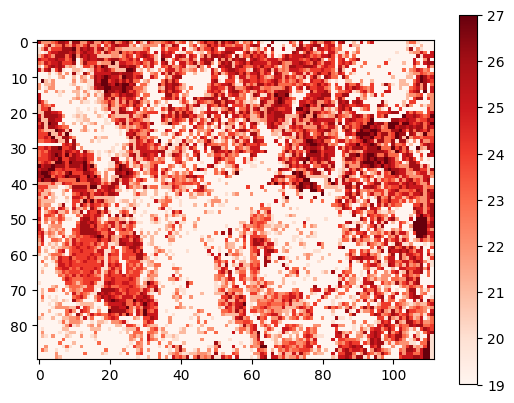

In [12]:
os.chdir(static_write_dir)
test = read_pfb("pf_indicator.pfb")
print(test.shape)

cmap1 = "Reds"
sub_flip = np.zeros((1, nj, ni))
sub_flip[0, :, :] = test[0, :, :]
sub_flip = np.flip(sub_flip, 1)

plt.imshow(sub_flip[0, :, :], cmap=cmap1)
plt.colorbar()

### 8. Set up a baseline run from a reference yaml
This function will return the correct template yaml file to do your run based on the grid, if you're doing spin-up and if you're using a solid file with the necessary keys changed to run your subset with selected climate forcing at baseline for your specified start and end dates.

In [13]:
runscript_path = st.edit_runscript_for_subset(
    ij_bounds,
    runscript_path=reference_run,
    runname=runname,
    forcing_dir=forcing_dir,
)

New runname: conus1_upper_verde provided, a new yaml file will be created
Climate forcing directory has been changed to /home/ga6/subsettools_tutorial/inputs/conus1_upper_verde_conus1_2005WY/forcing  in runscript.
ComputationalGrid.NY set to 90 and NX to 112
GeomInput.domaininput.InputType detected as SolidFile, no additional keys to change for subset
Updated runscript written to /home/ga6/subsettools_tutorial/outputs/conus1_upper_verde_conus1_2005WY


### 9. Copy over your static files to your run directory
You may only need to do this once, or you may want to copy subset static files to different run directories for different runs.

In [14]:
st.copy_files(read_dir=static_write_dir, write_dir=pf_out_dir)

### 10. Change the file names in your runscript if desired
If you have changed the name of a static input file either from those used in the reference yamls provided, or have changed the name of an individual file for an ensemble or other experiment, you can change it with this function by providing the target runscript (yaml or pfidb) and the new file name(s) as an arguments. Only those arguments with a specified file name will be updated

In [15]:
init_press = os.path.basename(press_init_filepath)
runscript_path = st.change_filename_values(
    runscript_path=runscript_path,
    init_press=init_press,
)

Initial pressure filename changed to conus1_baseline_mod_2005.10.01:00.00.00_UTC0_press.pfb
Updated runscript written to /home/ga6/subsettools_tutorial/outputs/conus1_upper_verde_conus1_2005WY


### 11. Change processor topology if desired and then distribute your inputs and forcings to match the new topology

In [16]:
runscript_path = st.dist_run(
    topo_p=P,
    topo_q=Q,
    runscript_path=runscript_path,
    dist_clim_forcing=True,
)

Distributing your climate forcing
Distributed mask.pfb with NZ 1
Distributed slope_x.pfb with NZ 1
Distributed slope_y.pfb with NZ 1
Distributed pf_indicator.pfb with NZ 5
Distributed pme.pfb with NZ 5
Distributed ss_pressure_head.pfb with NZ 5
Distributed conus1_baseline_mod_2005.10.01:00.00.00_UTC0_press.pfb with NZ 5


### 12. Do a baseline run.
Load in the yaml run file you've created which is in the same folder as your static forcings and points to your climate forcing data. This assumes you do not want to make any changes from the parent model you used (Ex. conus1 baseline) and will run your subset at baseline conditions. Outputs should be almost identical to the parent model at your subset location for the same time period if you make no additional changes.

In [17]:
set_working_directory(f"{pf_out_dir}")
print(pf_out_dir)

# load the specified run script
run = Run.from_definition(runscript_path)
print(f"Loaded run with runname: {run.get_name()}")

# The following line is setting the run just for 10 hours for testing purposes
run.TimingInfo.StopTime = 10

run.run(working_directory=pf_out_dir)

/home/ga6/subsettools_tutorial/outputs/conus1_upper_verde_conus1_2005WY
Loaded run with runname: conus1_upper_verde

# ==============================================================================
# ParFlow directory
#  - /home/SHARED/software/parflow/3.10.0
# ParFlow version
#  - 3.10.0
# Working directory
#  - /home/ga6/subsettools_tutorial/outputs/conus1_upper_verde_conus1_2005WY
# ParFlow database
#  - conus1_upper_verde.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

